In [1]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

df = pd.read_csv("fuzzy_students_120.csv")
df.head()


,student_id,study_hours,sleep_hours,score
0,1,6.30,6.28,56.4
1,2,3.79,6.64,41.8
2,3,6.94,4.98,53.5
3,4,5.73,5.90,53.8
4,5,1.21,5.33,22.0


In [2]:
study = ctrl.Antecedent(np.arange(0, 8.5, 0.1), 'study')
sleep = ctrl.Antecedent(np.arange(4, 8.5, 0.1), 'sleep')
score = ctrl.Consequent(np.arange(20, 101, 1), 'score')


In [3]:
study['low'] = fuzz.trimf(study.universe, [0, 0, 3])
study['medium'] = fuzz.trimf(study.universe, [2.5, 4.5, 6.5])
study['high'] = fuzz.trimf(study.universe, [5.5, 8, 8])

sleep['short'] = fuzz.trimf(sleep.universe, [4, 4, 6])
sleep['ok'] = fuzz.trimf(sleep.universe, [5.5, 6.5, 7.5])
sleep['long'] = fuzz.trimf(sleep.universe, [7, 8, 8])

score['low'] = fuzz.trimf(score.universe, [20, 20, 55])
score['medium'] = fuzz.trimf(score.universe, [45, 65, 80])
score['high'] = fuzz.trimf(score.universe, [70, 100, 100])


In [4]:

rule1 = ctrl.Rule(study['high'] & sleep['ok'], score['high'])
rule2 = ctrl.Rule(study['medium'] & sleep['ok'], score['medium'])
rule3 = ctrl.Rule(study['low'], score['low'])
rule4 = ctrl.Rule(sleep['short'] & study['medium'], score['low'])
rule5 = ctrl.Rule(sleep['long'] & study['high'], score['high'])

# fallback / safety rule: if at least something is normal → medium score
rule6 = ctrl.Rule(study['medium'] | sleep['ok'], score['medium'])

ctrl_system = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])



In [5]:
ctrl_system = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
sim = ctrl.ControlSystemSimulation(ctrl_system)

# test a few students
sample = df.sample(5, random_state=10)
for _, row in sample.iterrows():
    sim.input['study'] = row['study_hours']
    sim.input['sleep'] = row['sleep_hours']
    sim.compute()
    print(f"ID {int(row.student_id)} -> Predicted Score: {sim.output['score']:.2f}")


ID 46 -> Predicted Score: 86.58
ID 80 -> Predicted Score: 63.86
ID 57 -> Predicted Score: 63.13
ID 86 -> Predicted Score: 32.96
ID 100 -> Predicted Score: 86.44


In [6]:
study_range = np.arange(0, 8.5, 0.5)
sleep_range = np.arange(4, 8.5, 0.5)
x, y = np.meshgrid(study_range, sleep_range)

z = np.zeros_like(x, dtype=float)

for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        sim = ctrl.ControlSystemSimulation(ctrl_system)   
        sim.input['study'] = float(x[i, j])
        sim.input['sleep'] = float(y[i, j])
        sim.compute()
        
        if 'score' in sim.output:
            z[i, j] = sim.output['score']
        else:
            z[i, j] = np.nan   # mark as empty


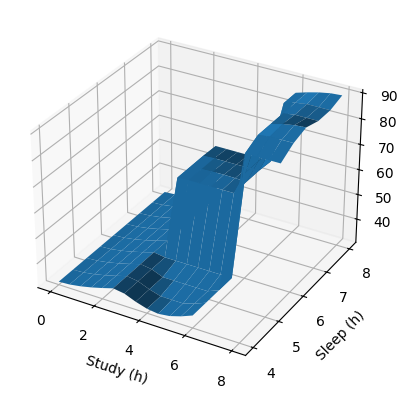

In [7]:
from mpl_toolkits.mplot3d import Axes3D  # noqa
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# if there are NaNs, matplotlib skips them
ax.plot_surface(x, y, z, linewidth=0, antialiased=True)

ax.set_xlabel('Study (h)')
ax.set_ylabel('Sleep (h)')
ax.set_zlabel('Score')
plt.show()
